In [31]:
import sys
import collections
sys.path.insert(0, '../')

import torch
import torchtext
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

from utils import load_dataset, train

In [32]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device = torch.device("cuda" if torch.cuda.is_available() else device)

In [33]:
dataset = load_dataset("../dataset/sqliv1.csv")
dataset_size = len(dataset)

In [34]:
tokenizer = torchtext.data.get_tokenizer("basic_english")

def create_vocab(dataset):
    counter = collections.Counter()
    for query, _ in dataset:
        counter.update(tokenizer(query))
    return torchtext.vocab.vocab(counter, min_freq=1)

vocab = create_vocab(dataset)
vocab_size = len(vocab)

In [35]:
batch_size = 16
query_len = 100

def pad_tensor(tensor, length):
    return torch.nn.functional.pad(tensor, (0, length - len(tensor)), mode='constant', value=0)

def process_batch(batch):
    labels = []
    tokens = [tokenizer(query) for query, _ in batch]
    encoded = [vocab.lookup_indices(tokens) for tokens in tokens]

    for _, label in batch:
        labels.append(int(label))

    l = max(map(len, tokens))

    padded_tensors = [pad_tensor(torch.LongTensor(t), l) for t in encoded]
    stacked_tensors = torch.stack(padded_tensors)

    return (stacked_tensors,
            torch.LongTensor(labels))

train_loader = DataLoader(dataset, batch_size=batch_size, collate_fn=process_batch, shuffle=True)

In [36]:
class BiLSTMNN(nn.Module):
    def __init__(self):
        super(BiLSTMNN, self).__init__()
        self.embedding = torch.nn.Embedding(num_embeddings=vocab_size, embedding_dim=128)
        self.bilstm = torch.nn.LSTM(128, 64, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(64*2, 2)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.bilstm(x)
        x = self.fc(x[:, -1, :])

        return x

network = BiLSTMNN().to(device)

traing...
320: accuracy=0.715625
640: accuracy=0.73125
960: accuracy=0.7302083333333333
1280: accuracy=0.73671875
1600: accuracy=0.73625
1920: accuracy=0.7395833333333334
2240: accuracy=0.7419642857142857
2560: accuracy=0.741015625
2880: accuracy=0.7388888888888889
3200: accuracy=0.740625
3520: accuracy=0.740909090909091
3840: accuracy=0.7424479166666667
4160: accuracy=0.7401442307692307
1 time epoch end
4536: accuracy=0.7389770723104057
4856: accuracy=0.7415568369028006
5176: accuracy=0.741112828438949
5496: accuracy=0.74108442503639
5816: accuracy=0.7393397524071527
6136: accuracy=0.7385919165580183
6456: accuracy=0.7391573729863693
6776: accuracy=0.7383412042502951
7096: accuracy=0.7394306651634723
7416: accuracy=0.7397518878101402
7736: accuracy=0.7396587383660806
8056: accuracy=0.7419314796425025
8376: accuracy=0.7420009551098377
2 time epoch end
8728: accuracy=0.7412923923006416
9048: accuracy=0.7416003536693192
9368: accuracy=0.7406063193851409
9688: accuracy=0.7404004954582989


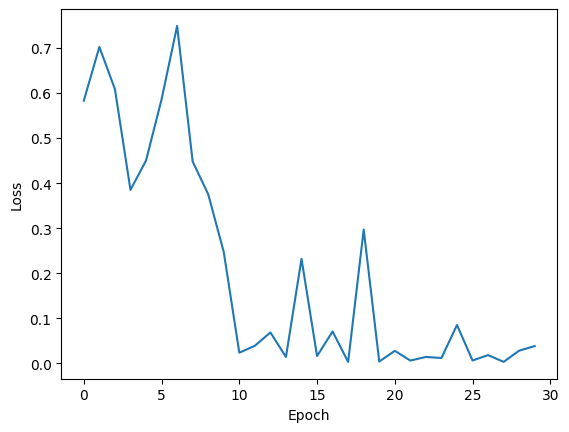

loss=0.013261614892825693, accurancy=0.912632531267856


In [37]:
hyperparameters = {
    "learning_rate": 0.01,
    "epoch": 30,
    "optimizer": optim.SGD(network.parameters(), lr=0.01),
    "lr_scheduler": None,
    "loss_fn": nn.CrossEntropyLoss(),
}

loss, accurancy = train(network, train_loader, device, dataset_size, 20, hyperparameters)
print(f"loss={loss}, accurancy={accurancy}")

# Save the model
torch.save(network.state_dict(), 'model.pth')